In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Mon Sep  9 22:44:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    88W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Importing the libraries

In [0]:
import numpy as np
from skimage import io
import torch
import os
from torch import nn
from torchvision.models.vgg import vgg16
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import torch.optim as optim

### Degrade function

In [0]:
def degrade(image):
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals

    return image

### Dataset Loader Class

In [0]:
class CustomDataset(Dataset):

    def __init__(self, inp_dir, transform=None):

        self.inp_dir = inp_dir
        self.transform = transform

        self.input_images = sorted([os.path.join(inp_dir,i) for i in os.listdir(inp_dir)])

    def __len__(self):

        return len(self.input_images)

    def __getitem__(self, idx):

        output_image = io.imread(self.input_images[idx])
        x = output_image.copy()
        input_image = degrade(x)

        dataset = dict()

        dataset["input"] = input_image
        dataset["output"] = output_image

        if self.transform:
            dataset = self.transform(dataset)

        return dataset

class ToTensor(object):

    def __call__(self, data):
        inp, out = data["input"], data["output"]

        inp = inp.transpose((2,0,1))/255.0
        out = out.transpose((2,0,1))/255.0

        return {
                "input": torch.from_numpy(inp),
                "output": torch.from_numpy(out)
                }



class CustomDatasetTest(Dataset):

    def __init__(self, inp_dir, transform=None):

        self.inp_dir = inp_dir
        self.transform = transform
        self.input_images = sorted([os.path.join(inp_dir,i) for i in os.listdir(inp_dir)])
        self.input_images_name = sorted(os.listdir(inp_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = io.imread(self.input_images[idx])
        image_name = self.input_images_name[idx]

        dataset = dict()

        dataset["image"] = image
        dataset["image_name"] = image_name

        if self.transform:
            dataset = self.transform(dataset)

        return dataset

class ToTensorTest(object):

    def __call__(self,data):
        img = data['image']
        img_name = data['image_name']
        img = img.transpose((2,0,1))/255.0

        return {
                'image': torch.from_numpy(img),
                'image_name': img_name
        }

### Generator Loss Class

In [0]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return  0.01*image_loss + 1 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

### Creating the Model

In [0]:
class Generator(nn.Module):
    def __init__(self):

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.block8 = nn.Sequential(nn.Conv2d(64, 3, kernel_size=9, padding=4))

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (F.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return F.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

### Training the model

In [8]:
from torchvision.utils import make_grid

# from loss import GeneratorLoss
# from model import Generator, Discriminator
# from dataloader_utils import CustomDataset, ToTensor

try:
    os.mkdir("model_checkpoint")
except:
    pass

epochs = 100
batch_size = 4

checkpoint_path = "/content/drive/My Drive/srgans/model_checkpoint/"

gen = Generator()
dis = Discriminator()

data = CustomDataset(inp_dir="/content/drive/My Drive/srgans/Data/train/",
                     transform=transforms.Compose([ToTensor()]))

dataloader = DataLoader(data, batch_size=batch_size, num_workers=4,shuffle=True)

generator_criterion = GeneratorLoss()
discriminator_criterion = torch.nn.BCELoss()

optimizerG = optim.Adam(gen.parameters())
optimizerD = optim.Adam(dis.parameters())

if torch.cuda.is_available():
    gen.cuda()
    dis.cuda()
    generator_criterion.cuda()
    discriminator_criterion.cuda()

for epoch in range(1, epochs + 1):

    running_results = {'batch_sizes': 0, 'd_loss': 0,
                       'g_loss': 0, 'epoch':epoch}

    gen.train()
    dis.train()
    for data in tqdm(dataloader):
        g_update_first = True
        running_results['batch_sizes'] += batch_size
        inp = data["input"].float()
        out = data["output"].float()
#         inp_batch = make_grid(inp).numpy().transpose((1,2,0))*255.0
#         out_batch = make_grid(out).numpy().transpose((1,2,0))*255.0
#         batch_images = np.concatenate((inp_batch,out_batch),axis=0)
#         io.imsave('/content/drive/My Drive/srgans/batch.jpg',batch_images)
#         break
        real_img = Variable(out)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(inp)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = gen(z)

        ####################Training the discriminator###############

        dis.zero_grad()
        real_out = dis(real_img)
        fake_out = dis(fake_img)
        real_labels = Variable(torch.ones(batch_size,1))
        fake_labels = Variable(torch.zeros(batch_size,1))
        if torch.cuda.is_available():
            real_labels = real_labels.cuda()
            fake_labels = fake_labels.cuda()
        real_loss = discriminator_criterion(real_out,real_labels)
        fake_loss = discriminator_criterion(real_out,fake_labels)
    
        
        d_loss = 0.5*(real_loss + fake_loss)
        d_loss.backward(retain_graph=True)
        optimizerD.step()
        
        ###################Training the generator################

        gen.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()
        running_results['g_loss'] += g_loss.data * batch_size
        running_results['d_loss'] += d_loss.data * batch_size
        # break

    print("Epoch: {}/{},  Loss_D: {},  Loss_G: {}".format(epoch,
                                                          epochs,
                                                          running_results["d_loss"] / running_results["batch_sizes"],
                                                          running_results["g_loss"] / running_results["batch_sizes"]))
  


    torch.save(gen.state_dict(), '{}New3_gen_epoch_{}.pth'.format(checkpoint_path, epoch))
    # torch.save(dis.state_dict(), '{}dis_epoch_{}.pth'.format(checkpoint_path, epoch))
    break

  0%|          | 0/2180 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
100%|██████████| 2180/2180 [53:08<00:00,  1.46s/it]

Epoch: 1/100,  Loss_D: 0.6932238936424255,  Loss_G: 0.5004241466522217


### Testing the model

In [11]:
model1 = Generator()
model1.load_state_dict(torch.load('/content/drive/My Drive/srgans/model_checkpoint/New3_gen_epoch_1.pth'))
model1.eval()
if torch.cuda.is_available():
    model1=model1.cuda()

try:
    os.makedirs("/content/drive/My Drive/srgans/results")
except:
    print("directory exists!")
    pass

batch_size= 1

data = CustomDatasetTest(inp_dir='/content/drive/My Drive/srgans/Data/test_degraded', transform=transforms.Compose([ToTensorTest()]))
dataloader = DataLoader(data, batch_size=batch_size, num_workers=4,shuffle=True)

image_counter= 0
for data in dataloader:
    print("image {}".format(image_counter+1))
    image_counter += 1
    image = data['image']
    image_name = data['image_name'][0]
    orig_image = io.imread('/content/drive/My Drive/srgans/Data/test/'+image_name)
    image_to_save = image.numpy()[0].transpose((1,2,0))*255.0
#     io.imsave('/content/drive/My Drive/srgans/results/z1{}.jpg'.format(image_counter),image_to_save)
    if torch.cuda.is_available():
        image=image.type('torch.FloatTensor').cuda()
    image_out = model1(image)
    image_out = image_out.cpu().detach().numpy()[0].transpose((1,2,0))*255.0
#     io.imsave("/content/drive/My Drive/srgans/results/zz1{}.jpg".format(image_counter),image_out)
    comb=np.concatenate((orig_image,image_to_save,image_out),axis=1)
    io.imsave('/content/drive/My Drive/srgans/results/zzz{}.jpg'.format(image_counter),comb)
    if image_counter> 5:
        break

directory exists!
image 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


image 2


image 3


image 4


image 5


image 6


### Viewing the Output Images
#### left image-> original image
#### middle image -> image after applying degrade function
#### right image -> output of gans

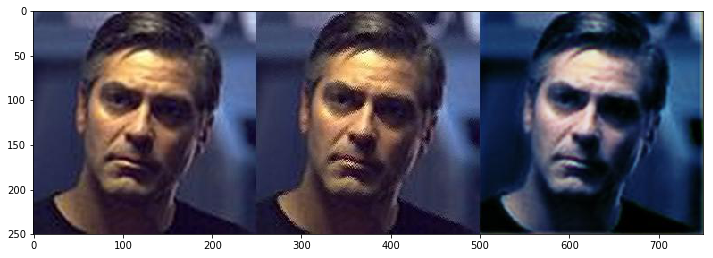

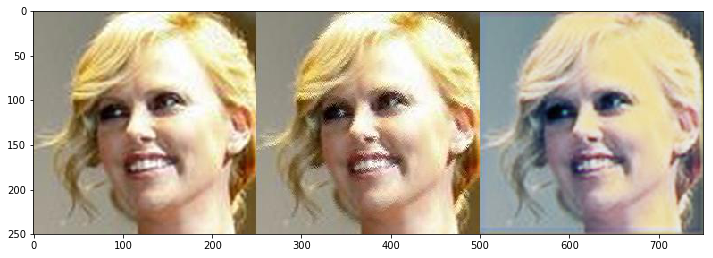

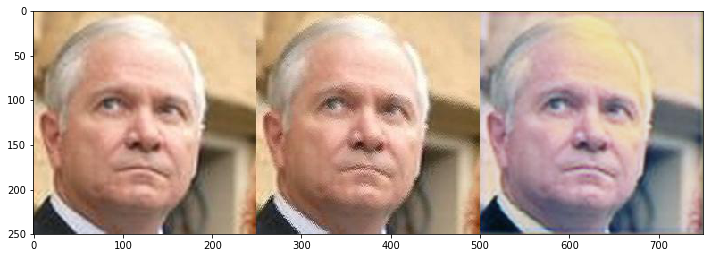

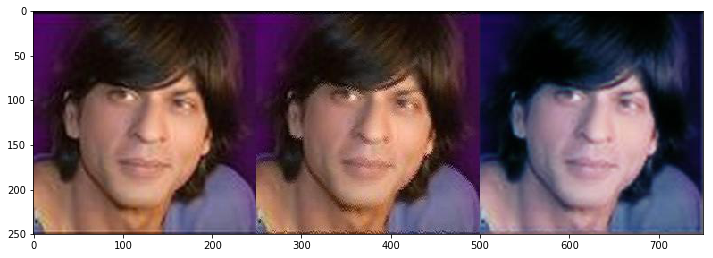

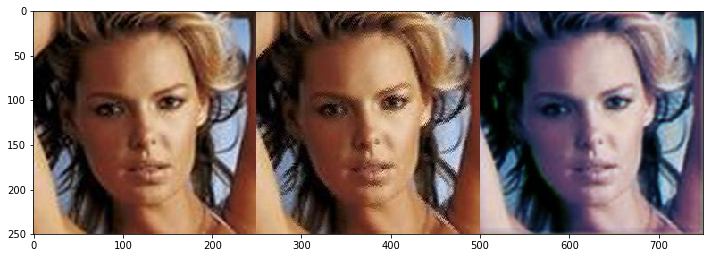

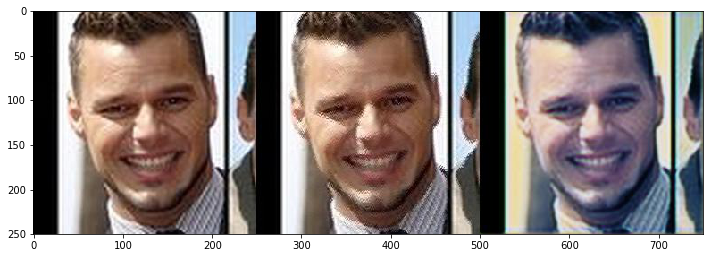

In [12]:
import matplotlib.pyplot as plt
for i in range(1,7):
    x = plt.imread('/content/drive/My Drive/srgans/results/zzz{}.jpg'.format(i))
    plt.figure(figsize=(12,12))
    plt.imshow(x)